```
This software is a part of GPU Ocean.

Copyright (C) 2019, 2020 SINTEF Digital

Read drift trajectories a deterministic forecast and ensemble forecast.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset

#Helpful during development
import importlib
#importlib.reload(module)

import datetime

from IPython.display import display

import matplotlib

from matplotlib import pyplot as plt
#Set large figure sizes
#plt.rcParams["animation.html"] = "jshtml" #Javascript 
plt.rcParams["animation.html"] = "html5" #mp4
plt.rcParams["figure.dpi"] = 100.0 #highres movies/plots

plt.rcParams["animation.writer"] = 'ffmpeg' 
plt.rcParams["animation.codec"] = 'h264' 

plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = 'serif'

In [2]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../')))

from SWESimulators import CDKLM16, Common, IPythonMagic, NetCDFInitialization
from SWESimulators import GPUDrifterCollection, Observation
from SWESimulators import DataAssimilationUtils as dautils

from demos.realisticSimulations import norkyst_plotting

In [3]:
%cuda_context_handler gpu_ctx

# Select area and result folder

In [4]:
case_name = 'lovese'

start_forecast_hours = 0
end_forecast_hours = start_forecast_hours + 24*3

# How many cells to erode of land
erode_land=1


In [5]:
fig_out_folder = os.path.abspath('phd_intro'+datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S"))
os.makedirs(fig_out_folder, exist_ok=True)

print("Figures will be placed in '" + fig_out_folder + "'")

Figures will be placed in '/home/havahol/playground/gpu-ocean/havahol-gpu-ocean/gpu_ocean/demos/MPI_SIR/phd_intro2020_01_13-08_34_20'


# Inspect URL and select area

In [6]:
# We need only the first file of the operational forecast

url_list = [
    'https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc',
    #'https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019071700.nc',
    #'https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019071800.nc',
    #'https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019071900.nc',
    #'https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019072000.nc',
    #'https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019072100.nc'
]


# Create simulator

For reading domain parameters

In [7]:
# Set initial conditions 
sim_args = {
    "gpu_ctx": gpu_ctx,
    "dt": 0.0,
    "rk_order": 2,
    "desingularization_eps": 1.0
}
data_args = NetCDFInitialization.getInitialConditionsNorKystCases(url_list, case_name, 
                                                                  timestep_indices=None, 
                                                                  erode_land=erode_land,
                                                                  download_data=False)

importlib.reload(CDKLM16)
sim = CDKLM16.CDKLM16(**sim_args, **NetCDFInitialization.removeMetadata(data_args))



This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


# Observation and forecast

In [8]:
observation_filename = '2019-12-03/lovese/opendrift_observations_18_08_56.pickle'
observation_args = {'observation_type': dautils.ObservationType.UnderlyingFlow,
                    'nx': sim.nx, 'ny': sim.ny,
                    'domain_size_x': sim.nx*sim.dx,
                    'domain_size_y': sim.ny*sim.dy,
                    'land_mask': sim.getLandMask()
                   }
observations = Observation.Observation(**observation_args)
observations.read_pickle(observation_filename)



# Deterministic forecast

In [9]:
deterministic_forecast_file = os.path.abspath("deterministic_forecast_2020_01_09-13_38_28/trajectory_forecast_0_to_72.pickle")

deterministic_trajectories = Observation.Observation(**observation_args)
deterministic_trajectories.read_pickle(deterministic_forecast_file)

# Ensemble forecast

Example command line for running these simulations:
```
mpirun -n 1 python sequential_importance_resampling.py --per_node_ensemble_size=10 --observation_file=2019-12-03/lovese/opendrift_observations_18_08_56.pickle --data_assimilation_end_hours=0 --forecast_duration_hours=72 --profile --perturb_forecast
```

In [10]:
#ensemble_folder_MC      = os.path.abspath("EPS_2020_01_10-10_36_47") # 10 members, 12 hours
#ensemble_folder_MC_pert = os.path.abspath("EPS_2020_01_10-10_56_27") # 10 members, 12 hours
#end_forecast_hours = start_forecast_hours + 12

#ensemble_folder_MC      = os.path.abspath("EPS_2020_01_10-10_36_47") # 10 members, 72 hours
#ensemble_folder_MC_pert = os.path.abspath("EPS_2020_01_10-14_05_25") # 10 members, 12 hours
#end_forecast_hours = start_forecast_hours + 72

ensemble_folder_MC      = os.path.abspath("EPS_2020_01_10-10_36_47") # 10 members, 12 hours
ensemble_folder_MC_pert = os.path.abspath("EPS_2020_01_12-20_36_32/") # 50 members, 72 hours
end_forecast_hours = start_forecast_hours + 72




In [11]:
def read_observations_from_EPS(eps_folder):
    drifter_forecast_dir = os.path.join(eps_folder, "forecast_observation_files")
    filenames = os.listdir(drifter_forecast_dir)

    drifter_forecast = [None] * len(filenames)
    for i in range(len(drifter_forecast)):
        drifter_forecast[i] = Observation.Observation(**observation_args)
        drifter_forecast[i].read_pickle(os.path.join(drifter_forecast_dir, filenames[i]))

    return drifter_forecast

ensemble_drifter_forecast_MC      = read_observations_from_EPS(ensemble_folder_MC)
ensemble_drifter_forecast_MC_pert = read_observations_from_EPS(ensemble_folder_MC_pert)


# Forecasted trajectories GLOBAL

In [111]:
def forecastPlot(ax, true_paths, ensemble_paths, color_id=0, 
                 forecast_point_size=2, truth_point_size=6, mean_paths=[None], plot_truth=True):
    """
    ax: Axis object to draw trajectories in
    true_path: A single list of paths that represents the truth
    ensemble_paths: Multiple lists of paths that represents the forecast
    color_id: integer representing a pre-defined color combination.
    """

    color_combinations = [
        # [true color, forecast color]
        #['xkcd:dark grey blue', 'xkcd:light blue grey', 'xkcd:wine'],
        ['xkcd:black', 'xkcd:light blue grey', 'xkcd:dark grey blue'],
        ['xkcd:scarlet', 'xkcd:light blue grey', 'xkcd:dark grey blue'],
        ['xkcd:viridian', 'xkcd:foam green'],
        ['xkcd:black', 'xkcd:light blue', 'xkcd:blue']
    ]
    
    assert(color_id < len(color_combinations)), 'Invalid color_id'
    
    true_color = color_combinations[color_id][0]
    forecast_color = color_combinations[color_id][1]
    mean_color = color_combinations[color_id][2]

    # Plot forecast paths 
    for paths in ensemble_paths:
        for path in paths:
            ax.plot(path[:,0], path[:,1], color=forecast_color, alpha=0.4)
        
        # Mark end position of forecast
        end_position   = paths[-1][-1,:]
        circ_end_forecast = matplotlib.patches.Circle((end_position[0], end_position[1]), 
                                                      forecast_point_size, 
                                                      fill=False, zorder=10,
                                                      alpha=0.8)
        ax.add_patch(circ_end_forecast)

    
    # Plot true path
    if plot_truth:
        for path in true_paths:
            ax.plot(path[:,0], path[:,1], color=true_color, zorder=5)
    
    # Plot mean path
    if mean_paths[0] is not None:
        for path in mean_paths:
            ax.plot(path[:,0], path[:,1], color=mean_color, zorder=6)
    
    # Mark start and end of true path
    start_pos = true_paths[0][0,:]
    end_pos   = true_paths[-1][-1,:]
    circ_start = matplotlib.patches.Circle((start_pos[0], start_pos[1]), 
                                           truth_point_size,
                                           fill=False, zorder=10)
    ax.add_patch(circ_start)
    #circ_end = matplotlib.patches.Circle((end_pos[0], end_pos[1]), 
    #                                     truth_point_size,
    #                                     fill=False, zorder=10)
    #ax.add_patch(circ_end)
    if plot_truth:
        ax.plot(end_pos[0], end_pos[1], 'x', color='k', zorder=11)
    
    # Mark end of mean path
    #if mean_paths[0] is not None:
        #ax.plot(mean_paths[-1][-1,0], mean_paths[-1][-1,1], 
        #           marker='o', markeredgecolor='k', markerfacecolor=None)
        
def createForecastCanvas(observation):
    """
    true_sim_reader: The SimReader object containing nx, ny, etc
    """   
    
    nx = observation.nx
    ny = observation.ny
    
    fig = plt.figure(figsize=(7,7))
    ax = plt.subplot(111)
    
    extent=np.array([0, observation.domain_size_x, 0, observation.domain_size_y])/1000
    ax.imshow(observation.land_mask, origin="lower", 
              extent=extent, cmap='binary')

    return ax


def plotAllDrifters(obs_file, ensemble_files= None, drifter_ids=None, ax = None, plot_truth=True,
                    xlim=None, ylim=None, color_id=0):
    
    if drifter_ids is None:
        drifter_ids = np.arange(obs_file.get_num_drifters(ignoreBuoys=True))
    
    num_drifters = len(drifter_ids)
    
    drifter_paths = [None]*num_drifters

    forecast_start_t = start_forecast_hours*3600
    forecast_end_t = end_forecast_hours*3600


    for i in range(num_drifters):
        drifter_paths[i] = obs_file.get_drifter_path(drifter_ids[i], forecast_start_t, forecast_end_t)
        
    ensemble_paths_drifters = [None]*len(drifter_ids)
    mean_paths=[None]*len(drifter_ids)
    
    if ensemble_files is not None:
        for d in range(len(drifter_ids)):
            ensemble_paths_drifters[d] = [None]*len(ensemble_files)
            for e in range(len(ensemble_files)):
                ensemble_paths_drifters[d][e] = ensemble_files[e].get_drifter_path(drifter_ids[d], 
                                                                                   forecast_start_t, 
                                                                                   forecast_end_t,
                                                                                   assume_no_boundary_trouble=True)
                if e == 0:
                    mean_paths[d] = ensemble_paths_drifters[d][e][0].copy()
                else:
                    mean_paths[d] += ensemble_paths_drifters[d][e][0]
            mean_paths[d] = mean_paths[d] / len(ensemble_files)
        
    else:
        for d in range(len(drifter_ids)):
            ensemble_paths_drifters[d] = []
        
    if ax is None:
        ax = createForecastCanvas(obs_file)
      
    for d in range(len(drifter_paths)):
        forecastPlot(ax, drifter_paths[d], ensemble_paths_drifters[d], mean_paths=[mean_paths[d]],
                     truth_point_size=1, plot_truth=plot_truth, forecast_point_size=0.6, color_id=color_id)
        
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)


(100, 400)

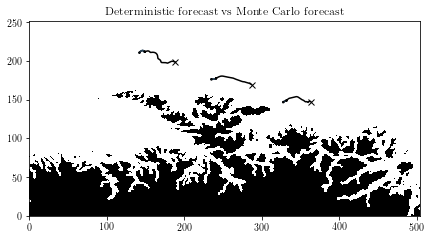

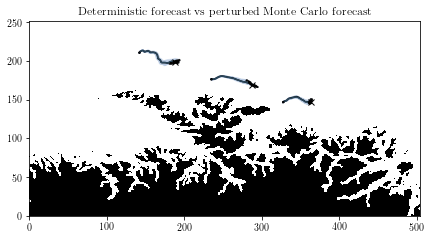

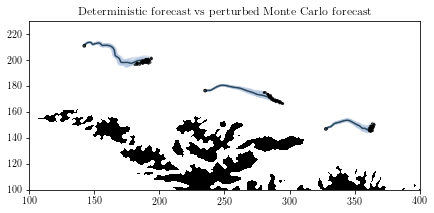

In [103]:
long_drifters = [12, 33, 34, 39, 49, 57, 58, 68]
aligned_drifters = [33, 49, 68]

plotAllDrifters(deterministic_trajectories, 
                ensemble_files=ensemble_drifter_forecast_MC, 
                drifter_ids=aligned_drifters)
plt.title('Deterministic forecast vs Monte Carlo forecast')


plotAllDrifters(deterministic_trajectories, 
                ensemble_files=ensemble_drifter_forecast_MC_pert, 
                drifter_ids=aligned_drifters)
plt.title('Deterministic forecast vs perturbed Monte Carlo forecast')


plotAllDrifters(deterministic_trajectories, 
                ensemble_files=ensemble_drifter_forecast_MC_pert, 
                drifter_ids=aligned_drifters,
                plot_truth=False)
plt.title('Deterministic forecast vs perturbed Monte Carlo forecast')
plt.ylim([100, 230])
plt.xlim([100, 400])


# Forecasted trajectories LOCAL

In [104]:
def makeDrifterPlots(drifter_id, deterministic_forecast, ensemble_forecast,
                     start_time_forecast, end_time_forecast, xlim=None, ylim=None):
    
    ensemble_paths = [None]*len(ensemble_forecast)
    for i in range(len(ensemble_paths)):
        ensemble_paths[i] = ensemble_forecast[i].get_drifter_path(drifter_id, 
                                                                  start_time_forecast, 
                                                                  end_time_forecast,
                                                                  assume_no_boundary_trouble=True)

    deterministic_path = deterministic_forecast.get_drifter_path(drifter_id, start_time_forecast, end_time_forecast)

    mean_path = ensemble_paths[0][0]
    
    num_paths_in_mean = 1
    for i in range(1, len(ensemble_paths)):
        if not np.isnan(ensemble_paths[i][0]).any():
            mean_path += ensemble_paths[i][0]
            num_paths_in_mean += 1

    mean_path /= num_paths_in_mean



    #ax = createForecastCanvas(obs)
    fig, axs = plt.subplots(1, 1, figsize=(7,7))

    print(len(ensemble_paths[0]))
    print(ensemble_paths[0][0].shape)
    forecastPlot(axs, deterministic_path, ensemble_paths, 
                 forecast_point_size=0.002, truth_point_size=0.001, mean_paths=[mean_path])

    # adjust plot for SIR paper
    if ylim is None:
        ylim = plt.ylim()
    if xlim is None:  
        xlim = plt.xlim()

    yint = range(int(np.floor(ylim[0])), int(np.ceil(ylim[1])+1))
    plt.yticks(yint)
    xint = range(int(np.floor(xlim[0])), int(np.ceil(xlim[1])+1))
    plt.xticks(xint)

    for tick in axs.xaxis.get_major_ticks():
        tick.label.set_fontsize(14)
        #tick.label.set_rotation('vertical')
        tick.label.set_y(-.02)
    for tick in axs.yaxis.get_major_ticks():
        tick.label.set_fontsize(14) 
        tick.label.set_x(-.02) 

    plt.ylim(ylim)
    plt.xlim(xlim)

    plt.tick_params(direction='in', length=6, width=3)

    #filename_fig = os.path.join(result_folder, "drifter_" + str(drifter_id) + "_fc_" + str(int(start_time_forecast/3600)) + "_to_" + str(int(end_time_forecast/3600)) + "_" + str(int(plt.rcParams["figure.dpi"])) + "_dpi")

    #fig.savefig(filename_fig + ".pdf", bbox_inches='tight')
    #plt.axis('equal')
    plt.gca().set_aspect('equal', adjustable='box')
    #fig.savefig(filename_fig + "_equal.pdf", bbox_inches='tight')

0 72
1
(144, 2)
1
(144, 2)
1
(144, 2)


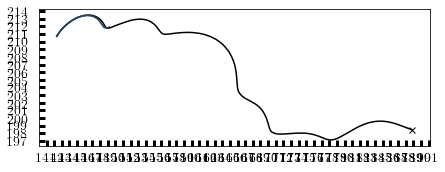

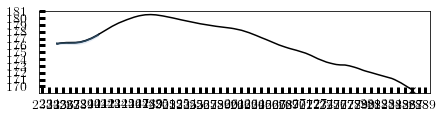

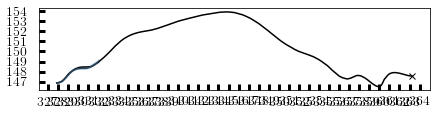

In [105]:
forecast_start_t = start_forecast_hours*3600
forecast_end_t = end_forecast_hours*3600
print(start_forecast_hours, end_forecast_hours)

for drifter_id in aligned_drifters:
    makeDrifterPlots(drifter_id, deterministic_trajectories, ensemble_drifter_forecast_MC,
                     forecast_start_t, forecast_end_t)

1
(864, 2)
1
(864, 2)
1
(864, 2)


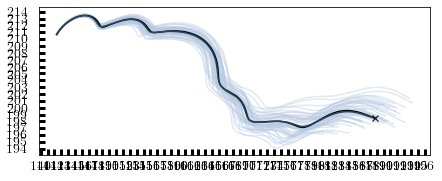

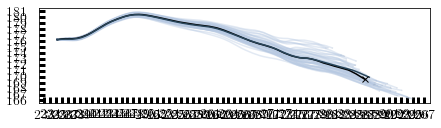

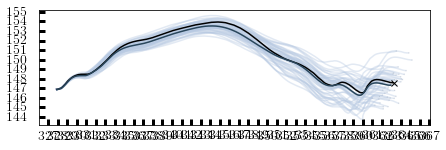

In [106]:
for drifter_id in aligned_drifters:
    makeDrifterPlots(drifter_id, deterministic_trajectories, ensemble_drifter_forecast_MC_pert,
                     forecast_start_t, forecast_end_t)

# Global plots with background fields

In [131]:
from SWESimulators import PlotHelper
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar

min, max V:  0.0 2.248424936757232


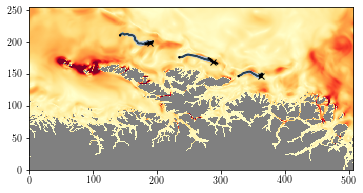

In [107]:

def getVfromReference(source_url, hour):
    use_case = NetCDFInitialization.getCaseLocation(case_name)
    x0 = use_case['x0']
    x1 = use_case['x1']
    y0 = use_case['y0']
    y1 = use_case['y1']

    ncfile = None
    try:
        ncfile = Dataset(source_url)
        H_m = ncfile.variables['h'][y0:y1, x0:x1]
        eta = ncfile.variables['zeta'][hour, y0:y1, x0:x1]
        hu = ncfile.variables['ubar'][hour, y0:y1, x0:x1]
        hv = ncfile.variables['vbar'][hour, y0:y1, x0:x1]
        
        x = ncfile.variables['X'][x0:x1]
        y = ncfile.variables['Y'][y0:y1]
        x = x - x[0]
        y = y - y[0]
        
        hu = hu * (H_m + eta)
        hv = hv * (H_m + eta)
        
    except Exception as e:
        raise e
    finally:
        ncfile.close()
        
    H_m.mask = eta.mask
    
    extent_x0 = (x1-x0)*800
    extent_y0 = (y1-y0)*800

    extent=np.array([0, extent_x0, 0, extent_y0]) / 1000




    
    V = PlotHelper.genVelocity(eta + H_m, hu, hv)
    V.mask = eta.mask
    return V, extent

#v_cmap=plt.cm.Wistia
v_cmap=plt.cm.YlOrRd
#v_cmap=plt.cm.hot_r

# Set land color
#land_color = 'xkcd:grey green' # 'grey'
land_color = 'grey'
v_cmap.set_bad(land_color, alpha=1.0)

V, extent = getVfromReference(url_list[0], 0)

#plt.show()
fig = plt.figure(figsize=(7,3))
ax = plt.subplot(111)
ax.imshow(V, origin='lower', extent=extent, cmap=v_cmap, vmin=0, vmax=0.6)
print('min, max V: ', V.min(), V.max())

plotAllDrifters(deterministic_trajectories, 
                ensemble_files=ensemble_drifter_forecast_MC_pert, 
                drifter_ids=aligned_drifters, ax=ax)


#plt.colorbar()
#plt.savefig(os.path.join(out_folder, 'velocity_gpuocean_forecasts_subset.pdf'), bbox_inches='tight')
#print(os.path.join(out_folder, 'velocity_gpuocean_forecasts_subset.pdf'))

min, max V:  0.0 2.248424936757232
min, max V:  0.0 2.248424936757232
min, max V:  0.0 2.248424936757232


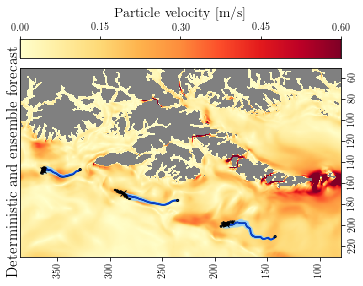

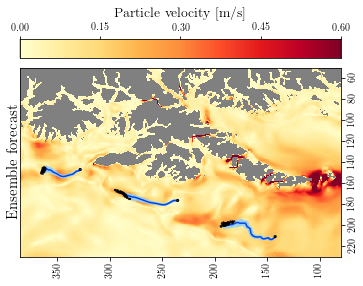

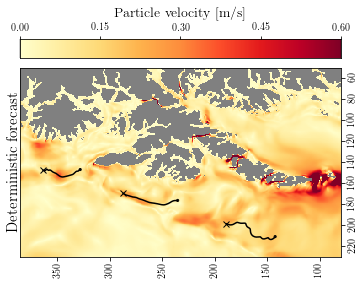

In [144]:

def addColorbar(ax, im, title):
        ax_divider = make_axes_locatable(ax)
        ax_cb = ax_divider.append_axes("top", size="10%", pad="5%")
        cbar = colorbar(im, cax=ax_cb, orientation="horizontal")
        ax_cb.xaxis.set_ticks_position("top")
        ax_cb.set_title(title, fontsize=14)
    
    
def introPlot(plot_truth=True, plot_ensemble=True, title="", filename=None):

    fig = plt.figure(figsize=(12,4))
    ax = plt.subplot(111)
    im = ax.imshow(V, origin='lower', extent=extent, cmap=v_cmap, vmin=0, vmax=0.6)
    addColorbar(ax, im, "Particle velocity [m/s]")
    print('min, max V: ', V.min(), V.max())

    
    
    if plot_ensemble:
        plotAllDrifters(deterministic_trajectories, 
                        ensemble_files=ensemble_drifter_forecast_MC_pert, 
                        drifter_ids=aligned_drifters, ax=ax,
                        plot_truth=plot_truth, color_id=3)
    else:
        plotAllDrifters(deterministic_trajectories, 
                        ensemble_files=None, 
                        drifter_ids=aligned_drifters, ax=ax,
                        plot_truth=plot_truth, color_id=3)


    ax.set_ylim([50, 230])
    ax.set_xlim([80, 385])

    
    # Trying to rotate the figure with drift trajectories and all
    # https://stackoverflow.com/questions/49517286/how-can-i-rotate-a-plot-x-axis-and-y-axis-using-pyplot

    #ax.set_ylabel("x", rotation=90)
    ax.yaxis.tick_right()
    ax.invert_yaxis()
    ax.yaxis.set_label_position("right")
    #ax.set_xlabel("y", rotation=180)
    ax.invert_xaxis()

    plt.setp(ax.get_xticklabels(), rotation=90, va="top", ha="center")
    plt.setp(ax.get_yticklabels(), rotation=90, va="center", ha="left")

    ax.text(-0.02,0.5,title, ha="center", va="center",
            transform=ax.transAxes, rotation=90, fontsize=15)
    
    if filename is not None:
        filename_path = os.path.join(fig_out_folder, filename)
        plt.savefig(filename_path+'.pdf', bbox_inches='tight')
        plt.savefig(filename_path+'.png', dpi=600, bbox_inches='tight')
        

introPlot(title='Deterministic and ensemble forecast', filename='det_and_ensemble_cb')
introPlot(plot_truth=False, title='Ensemble forecast', filename='ensemble_forecast_cb')
introPlot(plot_ensemble=False, title='Deterministic forecast', filename='deterministic_forecast_cb')

In [126]:
fig_out_folder

'/home/havahol/playground/gpu-ocean/havahol-gpu-ocean/gpu_ocean/demos/MPI_SIR/phd_intro2020_01_13-08_34_20'

min, max V:  0.0 1.7840373757895027
/home/havahol/playground/gpu-ocean/havahol-gpu-ocean/gpu_ocean/demos/MPI_SIR/deterministic_forecast_2020_01_09-13_38_28/velocity_gpuocean_forecasts_subset.pdf


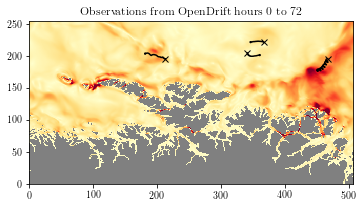

In [15]:

fig = plt.figure(figsize=(7,3))
ax = plt.subplot(111)
ax.imshow(V, origin='lower', extent=extent, cmap=v_cmap, vmin=0, vmax=0.6)
print('min, max V: ', V.min(), V.max())

plotAllDrifters(observations, drifter_ids=selected_drifters, ax=ax)
plt.title('Observations from OpenDrift '+ dt_string)

#plt.colorbar()
plt.savefig(os.path.join(out_folder, 'velocity_gpuocean_forecasts_subset.pdf'), bbox_inches='tight')
print(os.path.join(out_folder, 'velocity_gpuocean_forecasts_subset.pdf'))

min, max V:  0.0 1.7840373757895027
/home/havahol/playground/gpu-ocean/havahol-gpu-ocean/gpu_ocean/demos/MPI_SIR/deterministic_forecast_2020_01_09-13_38_28/velocity_gpuocean_forecasts_subset_annotated.pdf


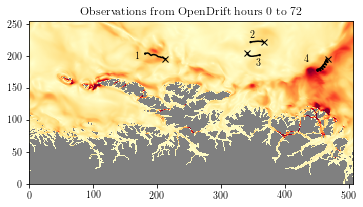

In [16]:
fig = plt.figure(figsize=(7,3))
ax = plt.subplot(111)
ax.imshow(V, origin='lower', extent=extent, cmap=v_cmap, vmin=0, vmax=0.6)
print('min, max V: ', V.min(), V.max())

# for annotation in annotations:
#        # Must be on the format [[label_1, xy_pos_1], [label_2, xy_pos_2],...]
#        ax.annotate(annotation[0], xy=annotation[1])

ax.annotate('1', xy=(166, 195))
ax.annotate('2', xy=(345, 230))
ax.annotate('3', xy=(355, 185))
ax.annotate('4', xy=(430, 190))



plotAllDrifters(observations, drifter_ids=selected_drifters, ax=ax)
plt.title('Observations from OpenDrift '+ dt_string)
#plt.colorbar()
plt.savefig(os.path.join(out_folder, 'velocity_gpuocean_forecasts_subset_annotated.pdf'), bbox_inches='tight')
print(os.path.join(out_folder, 'velocity_gpuocean_forecasts_subset_annotated.pdf'))